# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download and import libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [3]:
### Download libraries
#%pip install uproot
#%pip install awkward
#%pip install mplhep
#%pip install numpy
#%pip install matplotlib
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

In [1]:
import uproot
import awkward as ak
import mplhep
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams.update({'font.size': 11})

## Import Monte Carlo Samples and define Cuts
First, we will open the Monte Carlo samples using `uproot`.

The datasets are converted to a pandas data frame. Available keys are:

| Variable name | Description |
| --- | --- | 
| ``run`` | Run number |
| ``event`` | Event number |
| ``Ncharged`` | Number of charged tracks |
| ``Pcharged`` | Total scalar sum of track momenta |
| ``E_ecal`` | Total energy measured in the electromagnetic calorimeter |
| ``E_hcal`` | Total energy measured in the hadronic calorimete |
| ``E_lep`` | LEP beam energy (=$\sqrt{s}/2$) |
| ``cos_thru`` | cosine of the polar angle between beam axis and thrust axis |
| ``cos_thet`` | cosine of the polar angle between incoming positron and outgoing positive particle |

If ``cos_thru`` or ``cos_thet`` are undefined, the value ``999`` is used to idicate that. This is replaced by ``NaN`` to ensure correct behaviour in calculations.

Furthermore, we reject values larger $100\,\mathrm{MeV}$ for ``Pcharged`` as unphysical, replacing them also with ``NaN``. This is necessary, since outliers $>10000\,\mathrm{MeV}$ disturb the plotting routine and averaging procedures.

In [2]:
path_mc = 'opal_data/mc/'   # monte-carlo simulations

### Open the file introducing file path
ee = uproot.open(path_mc+'ee.root')
mm = uproot.open(path_mc+'mm.root')
tt = uproot.open(path_mc+'tt.root')
qq = uproot.open(path_mc+'qq.root')
ttree_name = 'myTTree'

### Get list of 'branches' of the TTree (i.e. list of variable names)
keys = ee[ttree_name].keys()

## Load branches
ee_branches = ee[ttree_name].arrays()
mm_branches = mm[ttree_name].arrays()
tt_branches = tt[ttree_name].arrays()
qq_branches = qq[ttree_name].arrays()

## Convert to pandas data frame
simulated_electron = ak.to_pandas(ee_branches)
simulated_muon = ak.to_pandas(mm_branches)
simulated_tau = ak.to_pandas(tt_branches)
simulated_quark = ak.to_pandas(qq_branches)

## Efficiency correction factor (between nominal 100,000 events and the actual number of events)
eff_corr_electons = len(simulated_electron) / 1e5
eff_corr_muons = len(simulated_muon) / 1e5
eff_corr_taus = len(simulated_tau) / 1e5
eff_corr_quarks = len(simulated_quark) / 1e5

## Delete photon-photon entries
simulated_electron = simulated_electron[simulated_electron['Pcharged']!=0]
simulated_muon = simulated_muon[simulated_muon['Pcharged']!=0]
simulated_tau = simulated_tau[simulated_tau['Pcharged']!=0]
simulated_quark = simulated_quark[simulated_quark['Pcharged']!=0]

## Iterable arrays of different event types
simulated_datasets = {'electron': simulated_electron, 'muon': simulated_muon, 'tau': simulated_tau, 'quark': simulated_quark}
efficiency_corrections = {'electron': eff_corr_electons, 'muon': eff_corr_muons, 'tau': eff_corr_taus, 'quark': eff_corr_quarks}

## Use correct NaN specifier for undefined values
for particle, dataset in simulated_datasets.items():
    dataset['cos_thru'].replace(999, np.nan, inplace=True)
    dataset['cos_thet'].replace(999, np.nan, inplace=True)
    dataset['Pcharged'].mask(dataset['Pcharged']>100, inplace=True)

### Visualization of the dataset

We can now look at the ditribution of values for the physical quantities of the dataset.

For that, we plot histograms of all keys in the data frame except ``run`` and ``event`` number and the LEP beam energy, which for those samples was always constant.

In [3]:
# Relevant variables within the sample
relevant_variables = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'cos_thru', 'cos_thet']

# Show histograms for each dataset with pandas
if False:   # set True to print all the histograms
    for particle, dataset in simulated_datasets.items():
        print(particle)
        diagram_list = dataset.hist(bins=50, column=relevant_variables)
        plt.tight_layout()
        plt.show()

For a better visualization of the parameter space, we can also plot each set of two variables in a scatter plot:

In [4]:
## get the default matplotlib color cycle as indexable array (needed to later prepare the legend)
prop_cycle = plt.rcParams['axes.prop_cycle']
default_colors = prop_cycle.by_key()['color']


## plot all combinations of interesting variables except for the angles
if False:
    for i in range(4):   # variable to be plotted on the x axis
        for j in range(i+1, 4):   # variable to be plotted on the y axis

            # plot faint datapoints
            for k, (particle, dataset) in enumerate(simulated_datasets.items()):
                plt.plot(dataset[relevant_variables[i]], dataset[relevant_variables[j]], '.', ms=0.2, alpha=0.1)   # actual data
                plt.plot([], [], '.', color=default_colors[k], ms=5, alpha=1, label=particle)   # better visible dots for legend

            plt.xlabel(relevant_variables[i])
            plt.ylabel(relevant_variables[j])
            plt.grid()
            plt.legend()
            plt.show()

### Declaring cuts

Separating the quark contributions is easily possible by their large number of charged traces:

We declare all events with `Ncharged >= 10` to be quark events, all with `Ncharged <=6` to be non-quark events.

For the leptons we could see the largest spread in the `Pcharged`-`E_ecal` 2D plot, there we choose regions differenciate the three types.

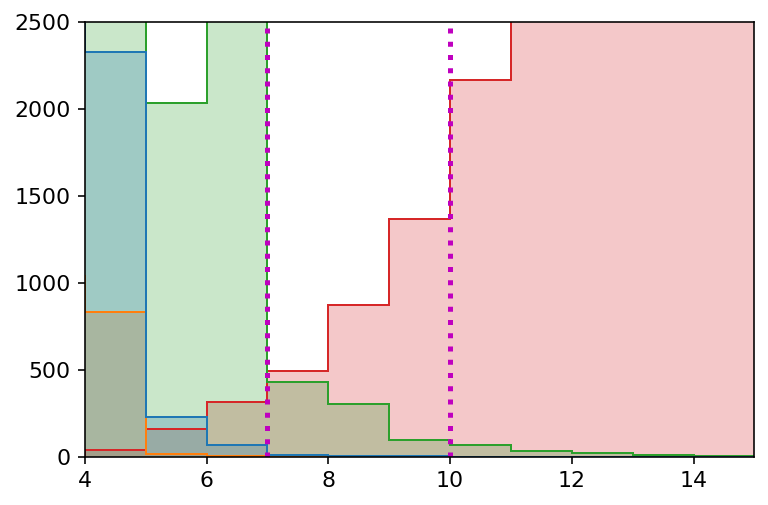

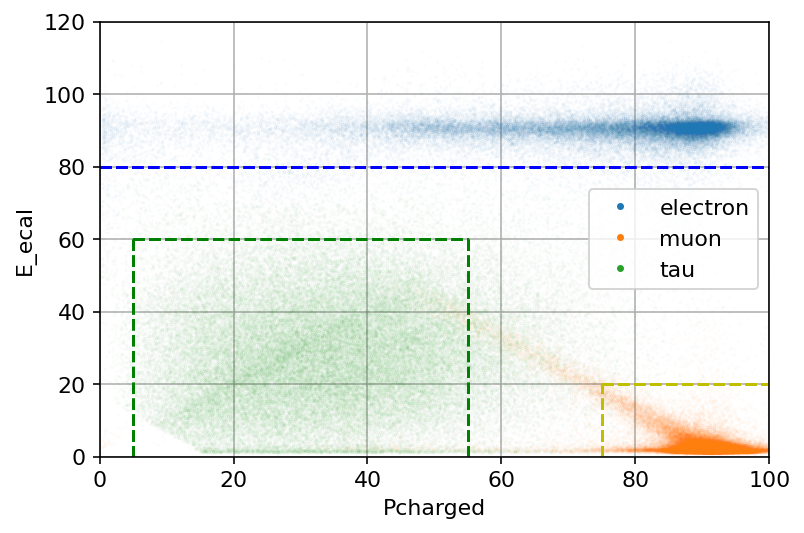

In [5]:
## declare cuts
Nmin_quarks = 10
Nmax_leptons = 6
Emin_ele = 80
Emax_muons = 20
Pmin_muons = 75
Emax_taus = 60
Pmin_taus = 5
Pmax_taus = 55



## plot histogram
histogram_data = [simulated_electron['Ncharged'],simulated_muon['Ncharged'],simulated_tau['Ncharged'],simulated_quark['Ncharged']]
plt.hist(histogram_data, histtype='step', bins=48, color=default_colors[:4])   # outline
plt.hist(histogram_data, histtype='stepfilled', bins=48, alpha=0.25, color=default_colors[:4])   # filling
plt.plot([Nmin_quarks, Nmin_quarks], [0, 1e4], c='m', ls=':', lw=2.5)  # plot separating lines
plt.plot([Nmax_leptons+1, Nmax_leptons+1], [0, 1e4], c='m', ls=':', lw=2.5)  # plot separating lines
plt.plot()
plt.xlim(4,15)
plt.ylim(0,2500)
#plt.savefig('figures/selection_histogram.pdf')
plt.show()


## scatter plot
for k, (particle, dataset) in enumerate(simulated_datasets.items()):
    if particle != 'quark':
        plt.plot(dataset['Pcharged'], dataset['E_ecal'], '.', ms=0.2, alpha=0.1)   # actual data
        plt.plot([], [], '.', color=default_colors[k], ms=5, alpha=1, label=particle)   # better visible dots for legend
    
    ## visualize cuts by plotting separating lines
    plt.plot([0, 100], [Emin_ele, Emin_ele], c='b', ls='--', lw=1.5)
    plt.plot([Pmin_muons, Pmin_muons], [0, Emax_muons], c='y', ls='--', lw=1.5)
    plt.plot([Pmin_muons, 100], [Emax_muons, Emax_muons], c='y', ls='--', lw=1.5)
    plt.plot([Pmin_taus, Pmax_taus], [Emax_taus, Emax_taus], c='g', ls='--', lw=1.5)
    plt.plot([Pmin_taus, Pmin_taus], [0, Emax_taus], c='g', ls='--', lw=1.5)
    plt.plot([Pmax_taus, Pmax_taus], [0, Emax_taus], c='g', ls='--', lw=1.5)

plt.xlabel('Pcharged')
plt.ylabel('E_ecal')
plt.grid()
plt.legend()
plt.xlim(0, 100)
plt.ylim(0,120)
#plt.savefig('figures/selection_scatter.pdf')
plt.show()


## define functions to produce the cutting mask on any dataset

def electron_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] >= Emin_ele), axis=0)

def muon_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] <= Emax_muons, dataset['Pcharged'] >= Pmin_muons), axis=0)

def tau_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] <= Emax_taus,
                   dataset['Pcharged'] >= Pmin_taus, dataset['Pcharged'] <= Pmax_taus), axis=0)

def quark_mask(dataset):
    return dataset['Ncharged'] >= Nmin_quarks

## Iterable array of different selection types
selection_masks = {'electron': electron_mask, 'muon': muon_mask, 'tau': tau_mask, 'quark': quark_mask}

In [8]:
## calculate and save selection rates
selection_rates = np.zeros((4,4))

for i, (particle, dataset) in enumerate(simulated_datasets.items()):
    for j, (rule_particle, selection_rule) in enumerate(selection_masks.items()):
        mask = selection_rule(dataset)
        selection_rates[i][j] = sum(mask)/len(mask) * efficiency_corrections[particle]
        print(f"Out of {len(mask)} " + particle + f"-events, {np.sum(mask)} passed the " + rule_particle + "-selection mask")

selection_rate_errors = np.sqrt(selection_rates)   # Poisson ststistics

Out of 52113 electron-events, 49656 passed the electron-selection mask
Out of 52113 electron-events, 0 passed the muon-selection mask


Out of 52113 electron-events, 35 passed the tau-selection mask
Out of 52113 electron-events, 0 passed the quark-selection mask


Out of 89887 muon-events, 1 passed the electron-selection mask


Out of 89887 muon-events, 82676 passed the muon-selection mask


Out of 89887 muon-events, 992 passed the tau-selection mask
Out of 89887 muon-events, 0 passed the quark-selection mask


Out of 78826 tau-events, 136 passed the electron-selection mask


Out of 78826 tau-events, 220 passed the muon-selection mask


Out of 78826 tau-events, 65184 passed the tau-selection mask
Out of 78826 tau-events, 148 passed the quark-selection mask


Out of 98561 quark-events, 7 passed the electron-selection mask


Out of 98561 quark-events, 0 passed the muon-selection mask


Out of 98561 quark-events, 193 passed the tau-selection mask
Out of 98561 quark-events, 95307 passed the quark-selection mask


## Import OPAL data

In [9]:
### Open opal data and read into pandas
path_OPAL = 'opal_data/data/'   # actual data  simulations
OPAL = uproot.open(path_OPAL+'daten_2.root')
OPAL_branches = OPAL[ttree_name].arrays()   # load branches
OPAL_data = ak.to_pandas(OPAL_branches)   # convert to pandas data frame
OPAL_data = OPAL_data[OPAL_data['Pcharged']!=0]   # remove photon-photon contributions

## Use correct NaN specifier for undefined values
OPAL_data['cos_thru'].replace(999, np.nan, inplace=True)
OPAL_data['cos_thet'].replace(999, np.nan, inplace=True)
OPAL_data['Pcharged'].mask(OPAL_data['Pcharged']>100, inplace=True)

## extract different event types
measured_electron = OPAL_data[electron_mask(OPAL_data)]
measured_muon = OPAL_data[muon_mask(OPAL_data)]
measured_tau = OPAL_data[tau_mask(OPAL_data)]
measured_quark = OPAL_data[quark_mask(OPAL_data)]

## Iterable array of different event types
measured_datasets = {'electron': measured_electron, 'muon': measured_muon, 'tau': measured_tau, 'quark': measured_quark}

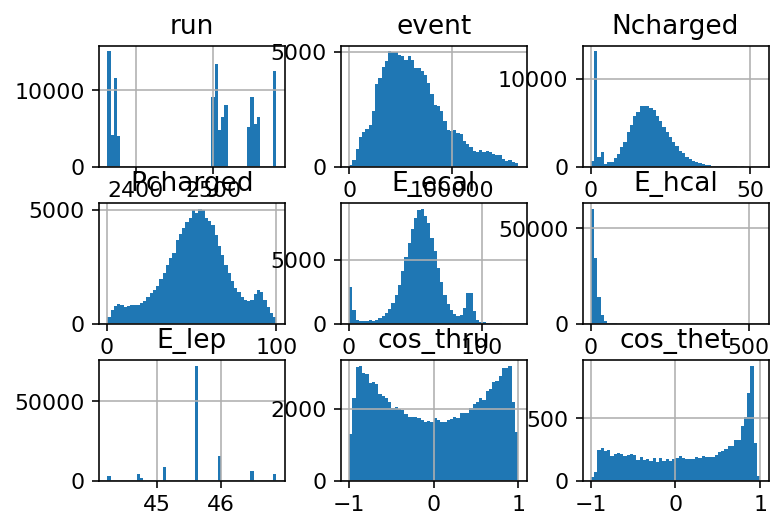

In [10]:
OPAL_data.hist(bins=52)
plt.show()

In [11]:
selection_rates

array([[8.93794660e-01, 0.00000000e+00, 6.29990597e-04, 0.00000000e+00],
       [1.04999611e-05, 8.68094781e-01, 1.04159614e-02, 0.00000000e+00],
       [1.36669424e-03, 2.21082891e-03, 6.55048509e-01, 1.48728491e-03],
       [7.00014204e-05, 0.00000000e+00, 1.93003916e-03, 9.53089340e-01]])

### Some useful information about your selection

In [11]:
print(f"Mean of {var}: ({pchar.mean()}) {np.nanmean(pchar)}")
print(f"Standard deviation of {var}: ({pchar.std()}) {np.nanstd(pchar)}")
print(f"Minimum value of {var}: ({pchar.min()}) {np.nanmin(pchar)}")
print(f"Maximum value of {var}: ({pchar.max()}) {np.nanmax(pchar)}")

NameError: name 'var' is not defined

### Make a plot with a certain selection

In [0]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

bin_content, bin_edges, _ = plt.hist(pchar[mymask],bins=1000,range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.title('My title')
plt.xlim(10.,150.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [0]:
matrix = np.array([[0.934, 0.02,  0.01, 0.],
                  [0.01,  0.946, 0.01, 0.01],
                  [0.01,  0.01,  0.965,0.01],
                  [0.01,  0.01,  0.01, 0.999]])

error_matrix = np.array([[0.001,   0.0001,  0.0001, 0.0001],
                        [0.0001,  0.001,   0.0001, 0.0001],
                        [0.0001,  0.0001,  0.001,  0.0001],
                        [0.0001,  0.0001,  0.0001, 0.001]])

### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4),dtype=object)
inverse_toys.fill([])

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))

    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    # Append values
    for j in range(0,4,1):
        for k in range(0,4,1):
            inverse_toys.item(j,k).append(toy_matrix.item(j,k))
    
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))

plt.figure(figsize=(20, 3))

# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        rmin = 0. ; rmax = 0.
        if j==k: 
            rmin = 0.8 ; rmax = 1.2
        else:
            rmin = -0.02 ; rmax = 0.02
        
        hbins, hedges, _ = plt.hist(inverse_toys.item(j,k),bins=500,range=(rmin,rmax),  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        plt.ylim(0.,1.2*max(hbins))


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins)
        h_fit = gauss(h_mid, *coeffs)
        
        plt.plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

In [17]:
## define fit function
def t_s_separation(cos_theta, A, B):
    return A * (1 + cos_theta**2) + B * (1 - cos_theta)**(-2)

## plot entire histogram and extract bins
electron_cos_theta, bin_edges, _ = plt.hist(simulated_electron['cos_thet'],bins=1000,range=(-0.85,0.85),  histtype='stepfilled', label='Pcharged')
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.tight_layout()
plt.clf()   #plt.show() if you also want to view the histogram

t_s_popt, t_s_pcov = curve_fit(t_s_separation, bin_centers, electron_cos_theta, p0=[43856111410946561, -1438679413876432], sigma=np.sqrt(electron_cos_theta))
t_s_perr = np.sqrt(np.diag(t_s_pcov))
thetas = np.linspace(-0.9, 0.9, 10000)


textstr = '\n'.join((
    r'$P_\mathrm{meas} = a \cdot P_\mathrm{nom}+b$',
    r'$A=(%.3f \pm %.3f)$' % (t_s_popt[0], t_s_perr[0]),
    r'$B=(%.2f \pm %.2f)$' % (t_s_popt[1], t_s_perr[1])))


props = dict(alpha=1, facecolor='w')

plt.errorbar(bin_centers, electron_cos_theta, yerr=np.sqrt(electron_cos_theta), fmt='.', ms=3, ecolor='r', elinewidth=1)
plt.plot(thetas, t_s_separation(thetas, *t_s_popt), c='purple')
plt.text(66, 10, textstr, fontsize=10, verticalalignment='top', bbox=props)

plt.xlabel('polar angle $\mathrm{cos}\,(\\theta)$')
plt.ylabel('counts')
plt.show()

print(t_s_popt, t_s_perr/t_s_popt*100)
print(t_s_popt[0]/t_s_popt[1])

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [0]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [0]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.